# Exploratory Data Analysis

Section 1 数据集基本情况（行数、列数、时间范围）。

Section 2 类别分布（fraud 占比）  

Section 3 时间分布（train/valid/test 的时间切分合理性）  

Section 4 金额和其他特征分布（长尾、偏态）  

Section 5 特征相关性（热图）  

Section 6 数据质量（缺失值、异常值）

Section 7 基线指标（随机预测 AUC-PR）

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
raw = pd.read_csv("../data/processed/train.csv", parse_dates=["event_time"])
tr = pd.read_csv("../data/processed/train.csv", parse_dates=["event_time"])
va = pd.read_csv("../data/processed/valid.csv", parse_dates=["event_time"])
te = pd.read_csv("../data/processed/test.csv",  parse_dates=["event_time"])

In [11]:
feature_cols = ["Amount"] + [c for c in tr.columns if c.startswith("V")]
X_tr, y_tr = tr[feature_cols], tr["Class"].values
X_va, y_va = va[feature_cols], va["Class"].values
X_te, y_te = te[feature_cols], te["Class"].values

## 数据质量

**结论1：数据高度不均衡, 欺诈案例太少（仅占所有数据的0.1%）** <br>
**结论2: 金额分布符合常理，大部分都小于2000欧元， 有显著偏态和长尾** <br>
**结论3: 没有缺失值**

In [12]:
#类别分布
print(raw['Class'].value_counts(normalize=True))

Class
0    0.998074
1    0.001926
Name: proportion, dtype: float64


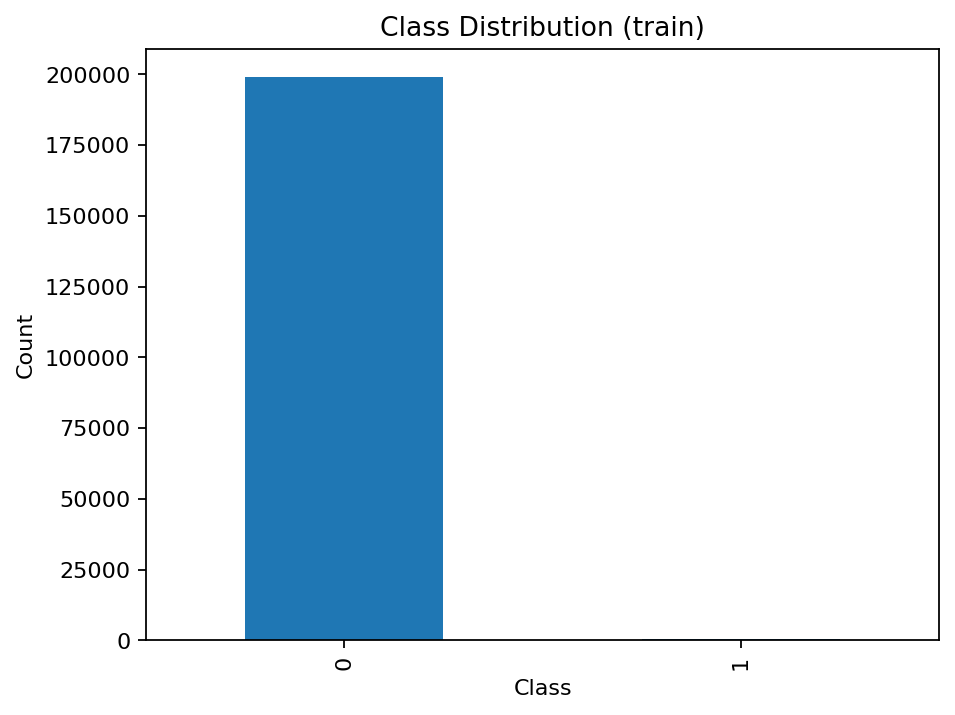

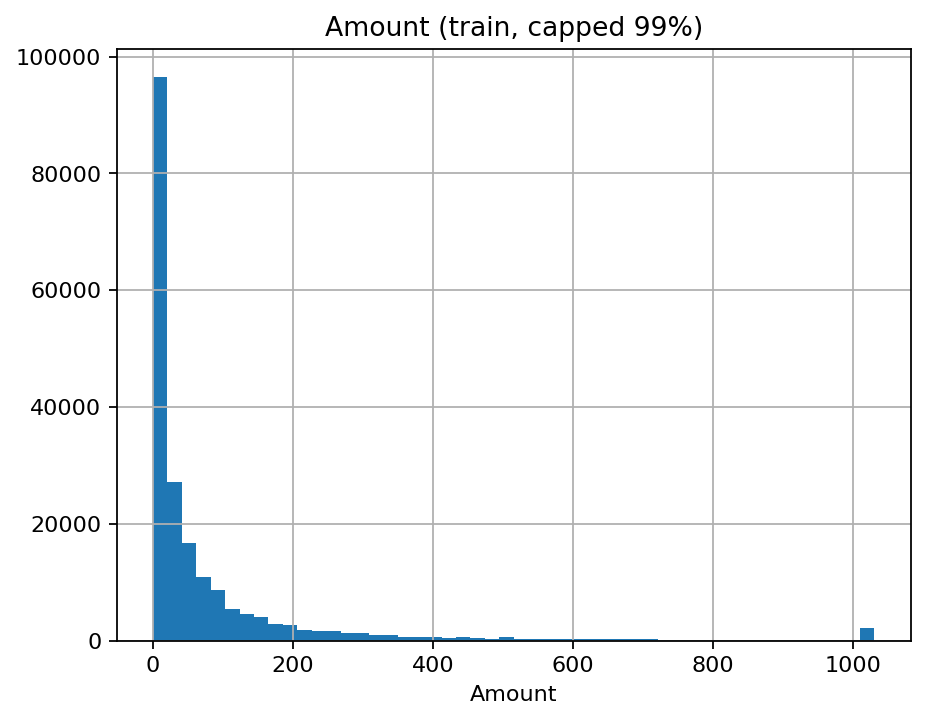

In [13]:
#类别及金额分布
from IPython.display import Image, display

display(Image(filename="figures/class_balance.png"))
display(Image(filename="figures/amount_hist.png"))

In [14]:
#时间切割合理，无重叠
tr["event_time"].max(), va["event_time"].min(), va["event_time"].max(), te["event_time"].min()

(Timestamp('2013-01-02 12:55:29'),
 Timestamp('2013-01-02 12:55:29'),
 Timestamp('2013-01-02 18:02:08'),
 Timestamp('2013-01-02 18:02:09'))

In [15]:
print(raw.isna().sum())
print(raw.describe())

tx_id         0
event_time    0
Amount        0
Class         0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
dtype: int64
               tx_id                     event_time         Amount  \
count  199365.000000                         199365  199365.000000   
mean    99682.000000  2013-01-01 19:34:04.729465856      89.771344   
min         0.000000            2013-01-01 00:00:00       0.000000   
25%     49841.000000            2013-01-01 12:17:18       5.990000   
50%     99682.000000            2013-01-01 18:40:32      23.000000   
75%    149523.000000            2013-01-02 01:23:29    

## 特征相关性

<Axes: >

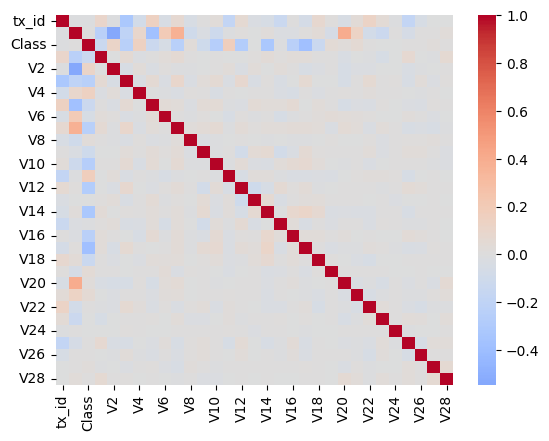

In [16]:
# 特征相关性热图
import seaborn as sns
corr = tr.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)

## Baseline
下图展示了：
 - 平均精度（AP, 也就是 AUC-PR）在极度不均衡下 ≈ 正样本占比。用作标尺对比。
 - 最小可行 LR（不采样、不调参）

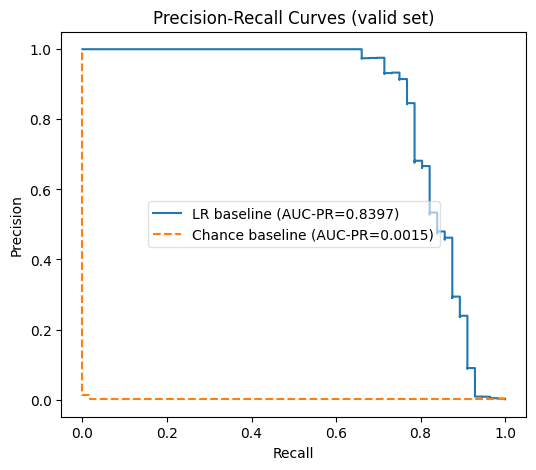

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ===== Logistic Regression Baseline =====
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None))
])
pipe.fit(X_tr, y_tr)
proba_lr = pipe.predict_proba(X_va)[:, 1]
ap_lr = average_precision_score(y_va, proba_lr)
p_lr, r_lr, _ = precision_recall_curve(y_va, proba_lr)

# ===== Chance Baseline (Dummy) =====
dc = DummyClassifier(strategy="stratified", random_state=42)
dc.fit(X_tr, y_tr)
proba_dc = dc.predict_proba(X_va)[:, 1]
ap_dc = average_precision_score(y_va, proba_dc)
p_dc, r_dc, _ = precision_recall_curve(y_va, proba_dc)

# ===== Plot both =====
plt.figure(figsize=(6,5))
plt.step(r_lr, p_lr, where="post", label=f"LR baseline (AUC-PR={ap_lr:.4f})")
plt.step(r_dc, p_dc, where="post", linestyle="--", label=f"Chance baseline (AUC-PR={ap_dc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (valid set)")
plt.legend(loc="center", framealpha=0.6)
plt.show()




LR baseline — ROC-AUC=0.9815, AUC-PR=0.8397


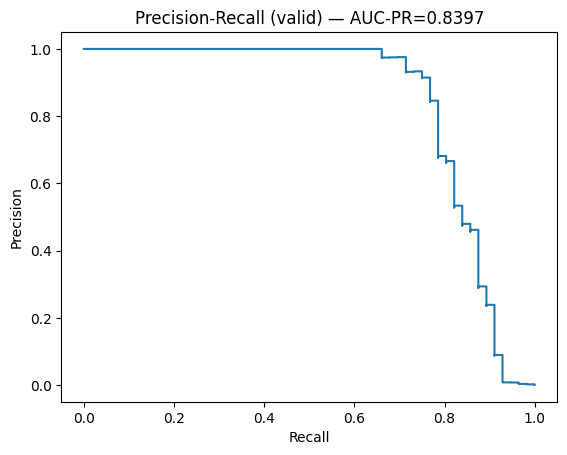

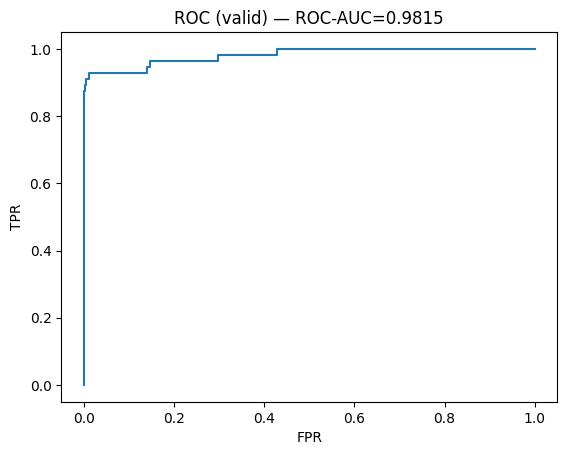

KS: 0.91628969881636
Confusion Matrix @0.5:
 [[41408  1257]
 [    4    52]]


In [18]:
import numpy as np
from sklearn.metrics import (roc_auc_score,
                             roc_curve,
                             confusion_matrix)


# ==== 构建 pipeline ====
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

pipe.fit(X_tr, y_tr)

# ==== 预测 ====
proba = pipe.predict_proba(X_va)[:, 1]

# ==== 指标 ====
roc_auc = roc_auc_score(y_va, proba)
ap = average_precision_score(y_va, proba)

print(f"LR baseline — ROC-AUC={roc_auc:.4f}, AUC-PR={ap:.4f}")

# ==== 曲线 ====
# PR
p, r, _ = precision_recall_curve(y_va, proba)
plt.figure()
plt.step(r, p, where="post")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall (valid) — AUC-PR={ap:.4f}")
plt.savefig("figures/pr_curve_baseline.png", dpi=160, bbox_inches="tight")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_va, proba)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC (valid) — ROC-AUC={roc_auc:.4f}")
plt.savefig("figures/roc_curve_baseline.png", dpi=160, bbox_inches="tight")
plt.show()

# ==== KS值 & 混淆矩阵 ====
ks = np.max(tpr - fpr)
print("KS:", ks)

pred_label = (proba >= 0.5).astype(int)
cm = confusion_matrix(y_va, pred_label)
print("Confusion Matrix @0.5:\n", cm)


**Baselin Interepretation:**
- ROC-AUC ≈ 0.98
- AUC-PR ≈ 0.83（远高于 fraud rate ≈ 0.17% 的机会线 → 模型显著有效）
- KS ≈ 0.90（非常高 → 模型能很好地区分正负类）
- FN远低于FP，符合信贷风险检测的产品条件（ie把漏报降到最低）
- 下一步：引进更强模型（XGBoost/ightGBM），用交叉验证，对比结果

# Model Development

产出：

reports/model_metrics.csv：存储各模型指标；

reports/figures/roc_curve_xgb_lgbm.png、pr_curve_xgb_lgbm.png；

Notebook 中生成一张对比表格 + 图表。


## Model Selection

In [19]:
import sys, os
sys.path.append(os.path.abspath("../src"))

In [20]:
from train import load_processed, build_lr_pipeline, try_build_xgb, try_build_lgbm, ks_stat

# Data Split and features constructed
(X_tr, y_tr), (X_va, y_va), (X_te, y_te), feature_cols = load_processed()

#LR 
model = build_lr_pipeline()
model.fit(X_tr, y_tr)
print("Valid AUC-PR:", average_precision_score(y_va, model.predict_proba(X_va)[:,1]))

scale_pos_weight = (len(y_tr)-sum(y_tr))/sum(y_tr)

models = ['LR', 'XGBoost', 'LGBM']
Model_func = [build_lr_pipeline(), try_build_xgb(scale_pos_weight), try_build_lgbm()]

rows = []

for i in range(len(models)):
    model = Model_func[i]
    model.fit(X_tr, y_tr)
    proba = model.predict_proba(X_va)[:, 1]
    # 验证集
    proba_va = model.predict_proba(X_va)[:, 1]
    va_roc  = roc_auc_score(y_va, proba_va)
    va_ap   = average_precision_score(y_va, proba_va)
    va_ks   = ks_stat(y_va, proba_va)

    # 测试集
    proba_te = model.predict_proba(X_te)[:, 1]
    te_roc  = roc_auc_score(y_te, proba_te)
    te_ap   = average_precision_score(y_te, proba_te)
    te_ks   = ks_stat(y_te, proba_te)

    rows.append({
            "model": models[i],
            "features": ",".join(feature_cols),
            "valid_roc_auc": float(va_roc),
            "valid_auc_pr": float(va_ap),
            "valid_ks": float(va_ks),
            "test_roc_auc": float(te_roc),
            "test_auc_pr": float(te_ap),
            "test_ks": float(te_ks),
        })

    # 汇总到报告
    out_df = pd.DataFrame(rows)
    out_df.to_csv( "model_metrics.csv", index=False)
    print("Saved:", "model_metrics.csv")


Valid AUC-PR: 0.8398422043255862
Saved: model_metrics.csv
Saved: model_metrics.csv
[LightGBM] [Info] Number of positive: 384, number of negative: 198981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199365, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Saved: model_metrics.csv


In [21]:
out_df

,model,features,valid_roc_auc,valid_auc_pr,valid_ks,test_roc_auc,test_auc_pr,test_ks
0,LR,"Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...",0.981520,0.839842,0.916290,0.976526,0.708247,0.847985
1,XGBoost,"Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...",0.988616,0.857147,0.918352,0.973130,0.765505,0.820176
2,LGBM,"Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...",0.987473,0.862721,0.919454,0.973290,0.774849,0.838279


Graphs for LGBM (current best model)

roc_curve_xgb_lgbm.png、pr_curve_xgb_lgbm.png

[LightGBM] [Info] Number of positive: 384, number of negative: 198981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199365, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


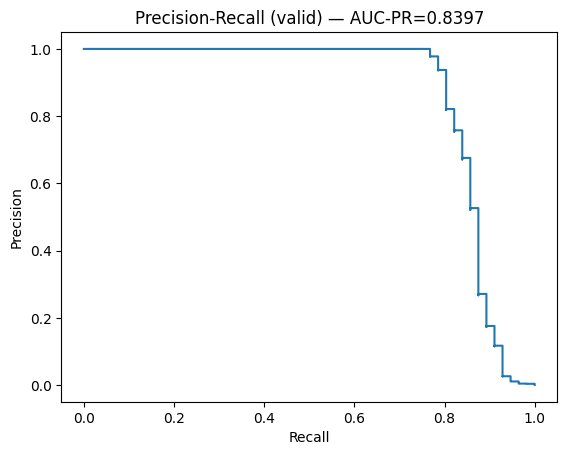

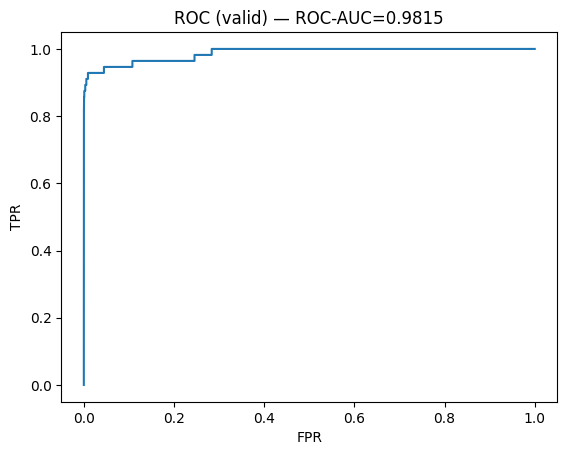

In [22]:
model = try_build_lgbm()
model.fit(X_tr, y_tr)
proba = model.predict_proba(X_va)[:, 1]

# PR
p, r, _ = precision_recall_curve(y_va, proba) # precision, recall, threshold
plt.figure()
plt.step(r, p, where="post")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall (valid) — AUC-PR={ap:.4f}")
plt.savefig("figures/roc_curve_xgb_lgbm.png", dpi=160, bbox_inches="tight")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_va, proba)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC (valid) — ROC-AUC={roc_auc:.4f}")
plt.savefig("figures/pr_curve_xgb_lgbm.png", dpi=160, bbox_inches="tight")
plt.show()

## Cross-Validation

🎯 Day 5 目标

在 CV 中对比：no-sampling / class_weight / RandomUnderSampler / SMOTE（可选再加 SMOTEENN）。（类别不平衡的常见处理方法）

- no sampling：什么都不做直接train
- class-weight：给少数类样本更高权重（baseline）
- RandomUnderSampler：随机采样，使不同类型样本数据量相似
- SMOTE：不是简单复制少数类，而是在少数类样本之间插值生成“合成样本”。
- SMOTEENN：在 SMOTE 过采样之后，再用 Edited Nearest Neighbour (ENN) 方法清理边界样本
    - ENN: 如果一个样本的类别和它 k 个最近邻的多数类别不一致，就删掉它。

以 AUC-PR 为主评分，输出对比表。


In [23]:
sys.argv = ["imbalance.py", "--folds", "5"]  # 模拟命令行参数
from imbalance import main
main()

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Could not import runpy module
Traceback (most recent call last):
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/joblib/__init__.py", line 114, in <module>
    from ._cloudpickle_wrapper import wrap_non_picklable_objects
  File "/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/joblib/_cloudpickle_wrapper.py", line 14, in <module>
    from .externals.loky import wrap_non_picklable_objects
  File "/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/joblib/externals/loky/__init__.py", line 21, in <module>
    from .reusable_executor import get_reusable_executor
  File "/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/joblib/externals/loky/re

KeyboardInterrupt: 

## 阈值优化
基于 config.yaml 的 成本矩阵 优化阈值，做 ±50% FN 成本灵敏度分析；给出 Recall@Precision≥0.90。

固化结果到 reports/，为 Dashboard 和 Day 6/7 做准备。

**原因：** 大多数分类模型输出的是概率（0到1的值），但在业务中，我们最终要做二分类决策，因此必须决定一个阈值，大于等于这个阈值的时候，判定为1。阈值优化的目标就是根据业务目标（最大化收益/最小化损失/满足具体constrains）来选择一个最合适的阈值

**业务意义：**
- 降低总体风险成本（between fp成本和fn成本）
- 满足监管/内部风控要求
- 提升业务策略可解释性

怎么做
- 从 models/ 载入你 Day 4 的最佳模型（或直接用当前最优 LR）。
- 在 valid 集上根据 config.yaml 中的成本矩阵搜索阈值。
- 做 FN 成本 ±50% 的灵敏度分析，画出阈值-期望成本曲线。
- 计算 Recall@Precision≥0.90（或你目标的 0.75/0.90 双线）。

*Note: 我们这里用的是手工法优化阈值（在config.yaml中定义决策成本），也可以利用scikit-learn中的TunedThresholdClassifierCV*


In [24]:
import joblib
from threshold import optimize_threshold, sensitivity_analysis, plot_sensitivity, threshold_nodes
from utils import load_config
from __future__ import annotations

In [25]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parents[0]))  # 把项目根目录加进来

cfg = load_config('../config.yaml')
model = try_build_lgbm()
model.fit(X_tr, y_tr)
predict_va = model.predict_proba(X_va)[:, 1]
predict_te = model.predict_proba(X_te)[:, 1]

[LightGBM] [Info] Number of positive: 384, number of negative: 198981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199365, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


最优阈值

In [26]:
# === 1. 阈值优化 ===
thr, cost = optimize_threshold(y_va, predict_va, cfg["costs"])
print("最佳阈值:", thr, "成本:", cost)


最佳阈值: 0.01 成本: 9085.0


灵敏度分析

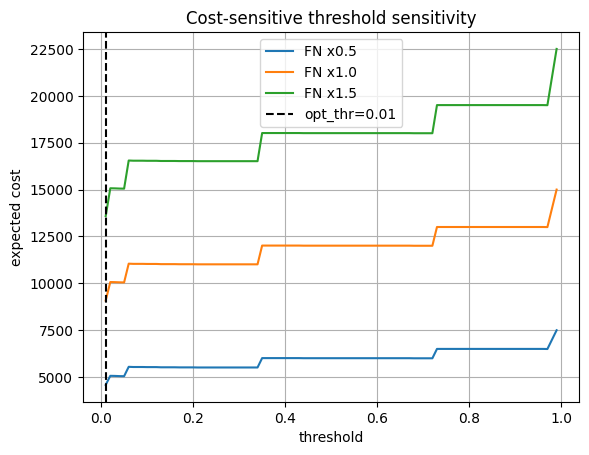

In [27]:
# === 2. 灵敏度分析 ===
df = sensitivity_analysis(y_va, predict_va, cfg["costs"])
plot_sensitivity(df, "figures/threshold_sensitivity.png", opt_thr=thr)

Test Set中阈值关键节点

In [28]:
# === 3. 导出关键阈值节点 ===
nodes = threshold_nodes(y_te, predict_te, [0.5, thr, 0.9])
nodes.to_csv("threshold_nodes.csv", index=False)
nodes

,thr,precision,recall,tp,fp,fn,tn
0,0.50,0.866667,0.750000,39,6,13,42663
1,0.01,0.579710,0.769231,40,29,12,42640
2,0.90,0.928571,0.750000,39,3,13,42666


Recall@Precision >= 0.75 or 0.9

背景设定：假设业务不允许误报太多，我们在给定的误报区域内，能达到最高的召回是多少

In [29]:
p, r, t = precision_recall_curve(y_te, predict_te) #precision, recall, threshold

r_at_p = dict()

for target_p in [0.5, 0.75, 0.90]:
    mask = p[:-1] >= target_p
    recall_at_p = r[:-1][mask].max() if mask.any() else 0.0
    print(f"Recall@Precision≥{target_p:.2f} = {recall_at_p:.3f}")
    r_at_p[target_p] = recall_at_p


Recall@Precision≥0.50 = 0.788
Recall@Precision≥0.75 = 0.750
Recall@Precision≥0.90 = 0.750


## Risk Memo for test set

	1.	表格汇总
	•	把 test 上的最终结果（最佳阈值、Precision、Recall、F1、期望成本、Recall@P≥0.75/0.90）汇总到一张表（reports/threshold_summary.csv），便于 Day 9 写 Risk Memo。
	2.	可视化（加分项）
	•	除了成本曲线，可以顺便画一张 PR 曲线 + 最优阈值点 标注在图上，更直观。

In [30]:
# 表格汇总目前model在test上的表现
from threshold import expected_cost

exp_c = expected_cost(y_te, predict_te, thr, cfg["costs"])

pred = (predict_te >= thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
P = tp / max(tp+fp,1); R = tp / max(tp+fn,1)

test_sum = [
    ("Best_thr", thr),
    ("Expectec_cost", exp_c),
    ("Precision@thr", P),
    ("Recall@thr", R),
    ("Recall@P>=0.75", r_at_p[0.75]),
    ("Recall@P>=0.9", r_at_p[0.9]),
]

test_df = pd.DataFrame(test_sum, columns=["Metric", "Value"])

test_df

,Metric,Value
0,Best_thr,0.010000
1,Expectec_cost,12145.000000
2,Precision@thr,0.579710
3,Recall@thr,0.769231
4,Recall@P>=0.75,0.750000
5,Recall@P>=0.9,0.750000


Precision-Recall曲线图

- 机会水平（prevalence）：正样本占比 - 假设我们根据这个概率进行random guess，它的precision就是在这条线上。因此越高于这条线，模型越有价值
- 理想情况的threshold取决于：业务目标/策略，成本矩阵，监管/kpi


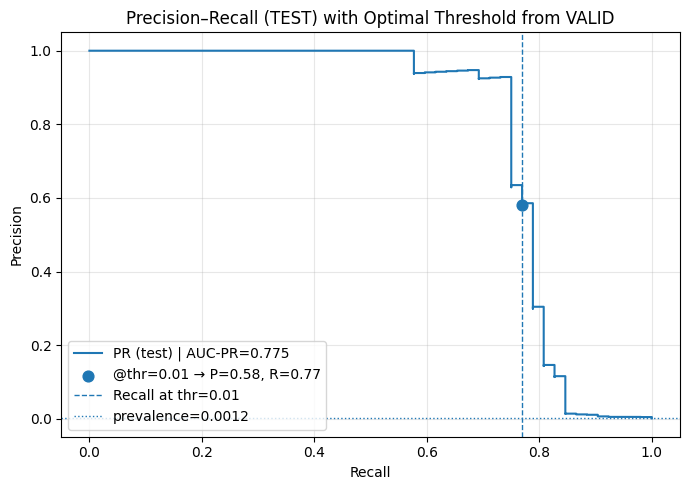

In [31]:
ap = average_precision_score(y_te, predict_te)

# 注意：precision_recall_curve 返回的 thresholds 长度比 precision/recall 少 1
idx = np.argmin(np.abs(t - thr))
r_at = r[idx]         # 该阈值下的 Recall
p_at = p[idx]         # 该阈值下的 Precision
prev = y_te.mean()  # 正样本占比（机会线）

plt.figure(figsize=(7,5))
plt.step(r, p, where="post", label=f"PR (test) | AUC-PR={ap:.3f}")
plt.scatter([r_at], [p_at], s=60, zorder=3, label=f"@thr={thr:.2f} → P={p_at:.2f}, R={r_at:.2f}")

# 竖直虚线：标记最优阈值对应的 Recall
plt.axvline(r_at, linestyle="--", linewidth=1, label=f"Recall at thr={thr:.2f}")

# 水平虚线：机会水平（正样本占比）
plt.axhline(prev, linestyle=":", linewidth=1, label=f"prevalence={prev:.4f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (TEST) with Optimal Threshold from VALID")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analysis and Reporting

🎯 Day 6 目标



业务策略建议

从 SHAP 提炼出几条人能看懂的风控规则（如：大额交易、深夜交易、特征 X>阈值 → 优先审核）。

这会在 Day 9 风控备忘录里用到。

✅ Day 6 产出 / 达标门槛 / 下一步

产出物

reports/figures/calibration_curves.png

reports/figures/shap_summary_bar.png

reports/figures/shap_summary_dot.png

reports/figures/shap_force_example.png

Notebook 文本单元里的 3–5 条业务策略建议

达标门槛

在 test 上对比 raw / Platt / Isotonic 概率分布 & Brier score

至少生成 一张全局 SHAP 图 和 一个局部解释

从结果提炼出业务可执行的启发

- 校准让模型的预测概率“更可信”，帮助你在 阈值+成本敏感优化 场景下更好决策。
- SHAP让模型“更透明”，帮助你在 解释+合规+业务理解 场景下更好落地。


## 校准

为什么：大多数模型的输出“分数” ≠ 真正的概率（尤其在极度不均衡任务里）。

方法：Platt scaling（逻辑回归） / Isotonic regression。

产出：校准曲线图、Brier score 对比。

In [32]:
# Calibration
from calibration_shap import _evaluate_probs, _plot_calibration_curves

/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,400
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [35]:
p_platt, p_iso, cali_df = _evaluate_probs(model, X_va, y_va, X_te, y_te, predict_te)
cali_df

/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


,model,brier,roc_auc,auc_pr
0,Isotonic,0.000402,0.976023,0.738169
1,Platt,0.000410,0.973290,0.774849
2,Raw,0.000437,0.973290,0.774849


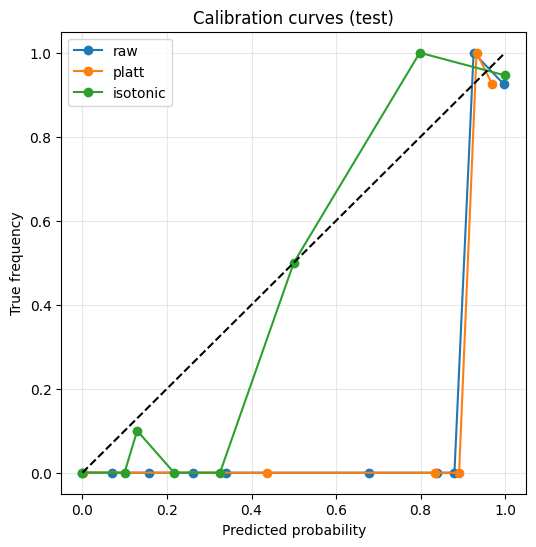

In [ ]:
_plot_calibration_curves(predict_te, p_platt, p_iso, y_te)

## SHAP

SHAP值的主要思想就是Shapley值，Shapley值是一个来自合作博弈论（coalitional game theory）的方法，由Shapley在1953年创造的Shapley值是一种根据玩家对总支出的贡献来为玩家分配支出的方法，玩家在联盟中合作并从这种合作中获得一定的收益。用shaply值去解释机器学习的预测的话，其中“总支出”就是数据集单个实例的模型预测值，“玩家”是实例的特征值，“收益”是该实例的实际预测减去所有实例的平均预测。

全局解释：哪个特征最重要？（例如 V14, V17, Amount）

局部解释：单一交易为什么被判为 fraud？

产出：SHAP summary plot + force plot。


In [ ]:
# Shap
from calibration_shap import shap_val, plot_shap_summary_bar, plot_shap_distribution_dot, explain_transaction

In [ ]:
explainer, shap = shap_val(model, X_te)

/Users/sarah/Downloads/risk-ml-suite/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:
np.save("shap_values_sample.npy", shap)

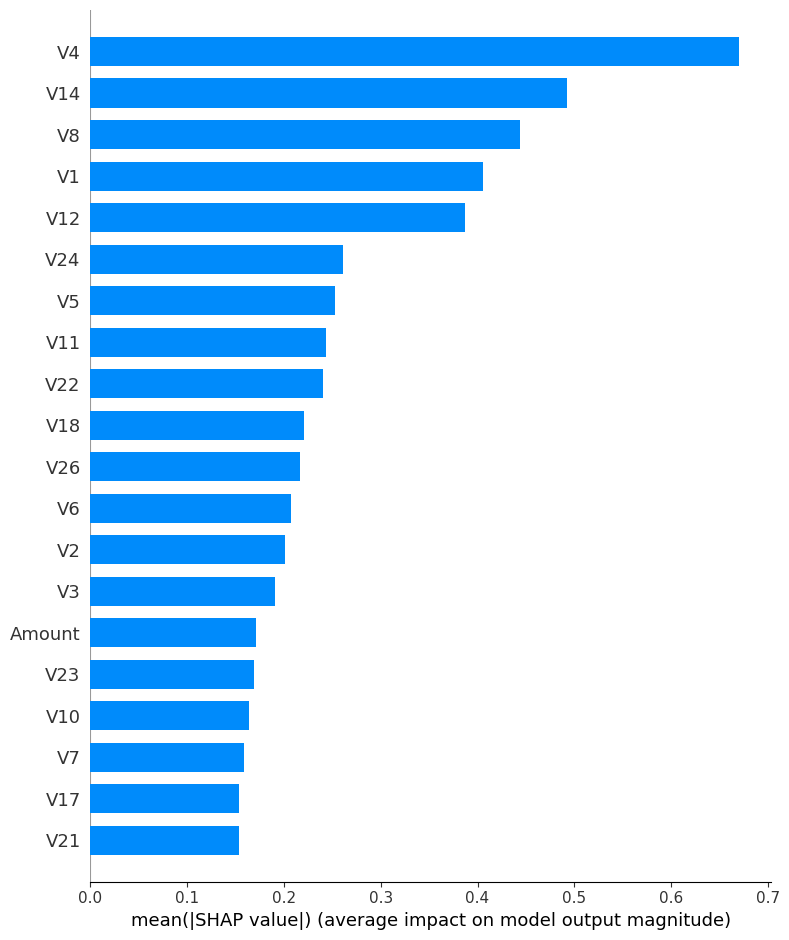

In [ ]:
plot_shap_summary_bar(shap, X_te)

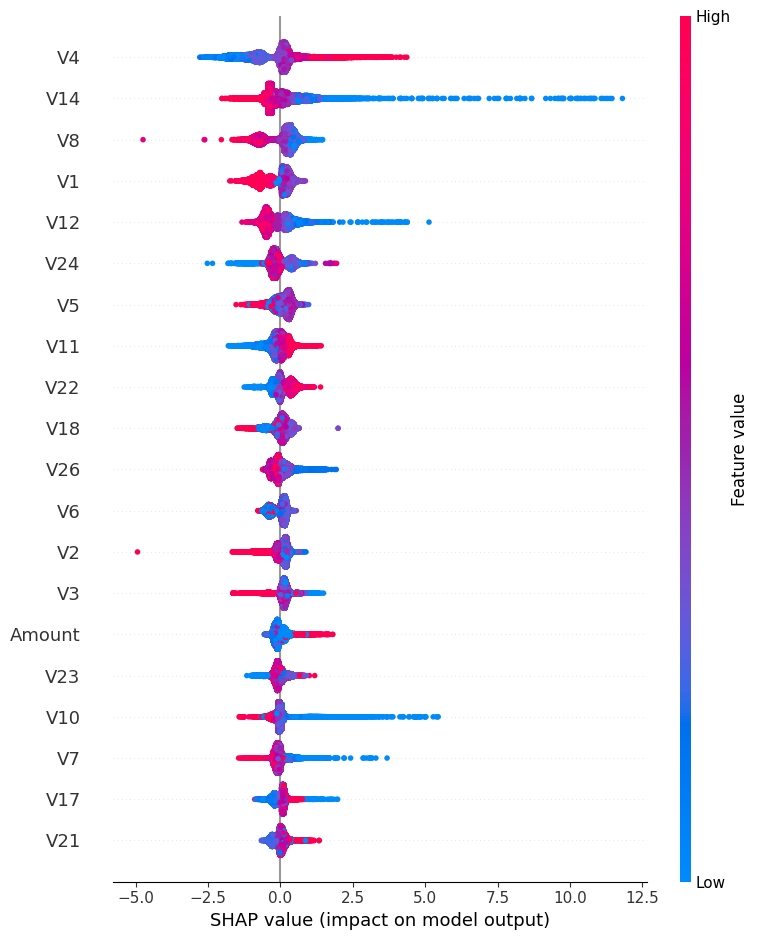

In [ ]:
plot_shap_distribution_dot(shap, X_te)

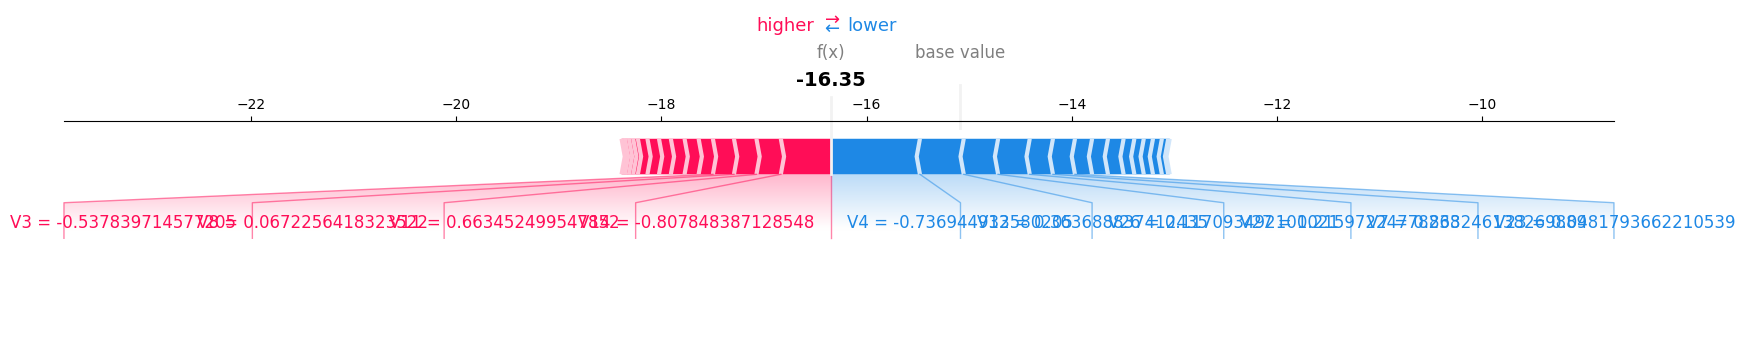

<Figure size 640x480 with 0 Axes>

In [ ]:
explain_transaction(explainer, shap, X_te, 100) # explain 100th transaction

In [ ]:
out_df

,model,features,valid_roc_auc,valid_auc_pr,valid_ks,test_roc_auc,test_auc_pr,test_ks
0,LR,"Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...",0.981520,0.839842,0.916290,0.976526,0.708247,0.847985
1,XGBoost,"Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...",0.988616,0.857147,0.918352,0.973130,0.765505,0.820176
2,LGBM,"Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...",0.987473,0.862721,0.919454,0.973290,0.774849,0.838279


In [ ]:
cali_df

,model,brier,roc_auc,auc_pr
0,Isotonic,0.000402,0.976023,0.738169
1,Platt,0.000410,0.973290,0.774849


# 业务策略建议

*例子：“因为 [指标/解释结果]，所以在业务上 [应该怎么做]，带来 [节省/风险降低/合规收益]。”*

1. 因为LGBM的AUC_PR = 0.77，为所有模型中最高，展现了其在极度不均衡任务里仍然能精准识别fraud的能力，所以在业务中选择LGBM作为检测欺诈的主模型，减少人工审核量。
2. 从阈值优化在test dataset上的fn数据和灵敏度graph，得出最优阈值（0.01）对fn以及成本上总体并不敏感，基本保持一致的趋势，说明该最优阈值风险较低。
3. 在校准实验中，Isotonic 的 Brier score 更低，说明概率预测更准确，但 AUC-PR 略有下降。因为 Brier 衡量的是概率可靠性，而 AUC-PR 衡量的是排序能力。Isotonic 会牺牲一点排序来换更好的概率校准。如果业务需要概率驱动的分层策略，我们会倾向于选择 Brier 更低的模型；如果只看排序和识别能力，则 Platt 或原模型就足够。
4. SHAP显示V4和V14最重要，可以在规则引擎中加入V4异常（异常高）的话，提高风险评分，或直接进入人工审核

# 稳定性与漂移监控

滚动/分层评估

按时间窗口（例如按月/周切分 test 集或合成流量），计算模型指标 (AUC-PR, Recall@Precision≥0.9, KS)

产出指标趋势图。

输入分布漂移监控


计算 PSI (Population Stability Index) 或 Jensen-Shannon Divergence。

对特征和模型输出概率做分布对比（train vs test，或不同时间段之间）。

标记告警阈值：

PSI < 0.1 → 稳定

0.1–0.25 → 轻微漂移

0.25 → 严重漂移

输出物

reports/figures/drift_metrics.png → 指标趋势 + PSI 条形图✅

reports/drift_summary.csv → 各特征 PSI 值 + 状态✅

src/drift.py → 可复用的漂移检测工具✅

In [ ]:
from drift import compute_drift_metrics, plot_drift_trend

In [ ]:
drift_metrics = compute_drift_metrics(model, te)
drift_metrics

/Users/sarah/Downloads/risk-ml-suite/src/drift.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  import matplotlib.pyplot as plt


,hour,auc_pr,roc_auc,count
0,2013-01-02 18:00,0.881319,0.977898,8162
1,2013-01-02 19:00,0.698721,0.985215,7655
2,2013-01-02 20:00,0.900500,0.974388,7776
3,2013-01-02 21:00,0.297619,0.998719,7808
4,2013-01-02 22:00,0.495944,0.946939,6464
5,2013-01-02 23:00,0.750888,0.942189,4856


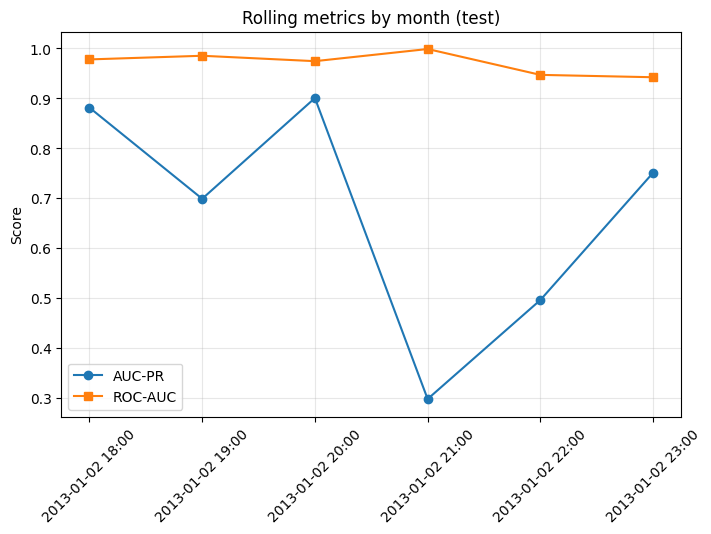

In [ ]:
plot_drift_trend(drift_metrics)

In [ ]:
from drift import compute_psi, psi_report

test = pd.read_csv("../data/processed/test.csv", parse_dates=["event_time"])
test["hour"] = test["event_time"].dt.to_period("H")

from src.drift import compute_psi
rows = []
for h, d in test.groupby("hour"):
    for f in feature_cols:
        psi = compute_psi(tr[f].values, d[f].values, bins=10)
        rows.append({"hour": str(h), "feature": f, "psi": psi})
psi_hourly = pd.DataFrame(rows)
psi_hourly.to_csv("psi_hourly.csv", index=False)

psi_hourly


/var/folders/zg/4k9h9dqx08q8fyj24lyqs5_40000gp/T/ipykernel_29494/1058003882.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test["hour"] = test["event_time"].dt.to_period("H")


,hour,feature,psi
0,2013-01-02 18:00,Amount,0.009122
1,2013-01-02 18:00,V1,1.041634
2,2013-01-02 18:00,V2,0.017542
3,2013-01-02 18:00,V3,0.689091
4,2013-01-02 18:00,V4,0.147317
...,...,...,...
169,2013-01-02 23:00,V24,0.160071
170,2013-01-02 23:00,V25,0.294419
171,2013-01-02 23:00,V26,0.158496
172,2013-01-02 23:00,V27,0.065505


In [ ]:
psi_report(tr, test, feature_cols)

,feature,psi,status
0,Amount,0.022791,stable
1,V1,1.013949,major_drift
2,V2,0.021410,stable
3,V3,0.750410,major_drift
4,V4,0.147965,slight_drift
5,V5,0.167457,slight_drift
6,V6,0.067535,stable
7,V7,0.074196,stable
8,V8,0.042067,stable
9,V9,0.063418,stable


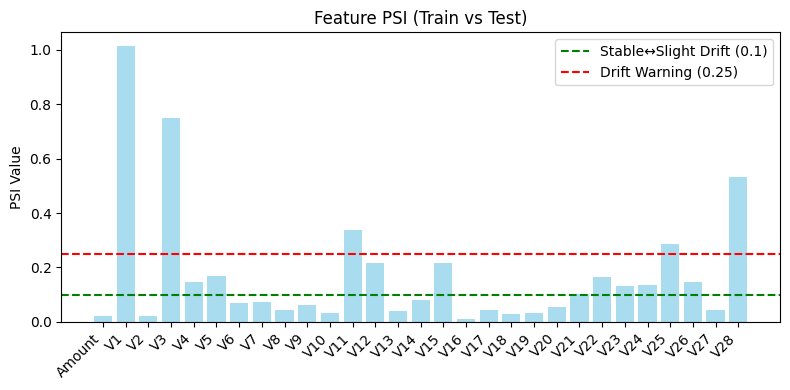

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("psi_feature_metrics.csv")  # 你的 train–test psi 文件

plt.figure(figsize=(8,4))
plt.bar(df["feature"], df["psi"], color="skyblue", alpha=0.7)
plt.axhline(0.1, color="green", linestyle="--", label="Stable↔Slight Drift (0.1)")
plt.axhline(0.25, color="red", linestyle="--", label="Drift Warning (0.25)")
plt.ylabel("PSI Value")
plt.title("Feature PSI (Train vs Test)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.savefig("figures/psi_features.png", dpi=170)
plt.show()



# Appendix / Draft Part

In [ ]:
# 1) 明确 Kaggle 特征（与 app 端一致）
feature_cols = ["Amount"] + [c for c in tr.columns if c.startswith("V")]

# 2) 用 ColumnTransformer 固定选列 + 标准化（避免将来列不一致）
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(with_mean=True), feature_cols)],
    remainder="drop",
    verbose_feature_names_out=False
)

# 3) 复用你 notebook 里已经挑好的“最终模型”
#    （可用你已有的 try_build_lgbm()，或已训练好的 best_estimator_）
from train import try_build_lgbm  # 如果函数就定义在 train.py
final_clf = try_build_lgbm()  # 举例
# 也可以直接用你已经fit过的 best_model（如 LogisticRegression）
# final_clf = LogisticRegression(max_iter=3000, class_weight="balanced")

export_pipe = Pipeline([("prep", preprocess), ("clf", final_clf)])
export_pipe.fit(tr[feature_cols], tr["Class"])

# 4) 导出
from pathlib import Path
import joblib, json, os
ROOT = Path.cwd().parents[0] if Path.cwd().name=="reports" else Path.cwd()
os.makedirs(ROOT/"models", exist_ok=True)
joblib.dump(export_pipe, ROOT/"models"/"lgbm_kaggle.joblib")

# 同步写出特征列，app 端使用
with open(ROOT/"models"/"kaggle_features.json", "w") as f:
    json.dump(feature_cols, f, indent=2)

print("Exported models/lgbm_kaggle.joblib with features:", len(feature_cols))


[LightGBM] [Info] Number of positive: 384, number of negative: 198981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199365, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Exported models/lgbm_kaggle.joblib with features: 29


In [ ]:
tr

,tx_id,event_time,Amount,Class,V1,V2,V3,V4,V5,V6,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0,2013-01-01 00:00:00,149.62,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1,2013-01-01 00:00:00,2.69,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,2,2013-01-01 00:00:01,378.66,0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,3,2013-01-01 00:00:01,123.50,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,4,2013-01-01 00:00:02,69.99,0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199360,199360,2013-01-02 12:55:27,40.46,0,1.921305,0.395242,-2.318680,1.398477,1.033023,-0.642820,...,-0.168052,-0.133742,0.037927,0.218286,-0.030503,0.589564,0.442069,-0.546391,-0.009510,-0.025723
199361,199361,2013-01-02 12:55:27,22.00,0,-0.638489,0.057029,1.022120,-1.267570,0.573539,0.253991,...,1.743075,0.541960,0.311661,0.787535,-0.433117,0.161191,0.591464,0.193631,0.072301,0.100244
199362,199363,2013-01-02 12:55:28,40.29,0,-1.590313,1.185834,0.929716,-0.429654,-0.092835,-0.578428,...,0.192490,0.027154,0.257901,1.159285,-0.544732,0.043616,1.113819,0.208993,-0.109086,-0.126385
199363,199362,2013-01-02 12:55:28,1745.40,0,-1.383590,-5.632354,-4.637217,1.364093,-0.042684,1.207176,...,-1.978109,3.161848,1.414935,0.395609,-1.539984,-0.423408,-0.330285,0.929866,-0.412846,0.196356


## Risk Memo and Model Card

### 目标产出

| 文件                          | 内容                          | 形式                        |
| --------------------------- | --------------------------- | ------------------------- |
| **`reports/model_card.md`** | 模型卡（Model Card）             | Markdown 文件（可在 GitHub 渲染） |
| **`reports/risk_memo.pdf`** | 风控备忘录（Risk Management Memo） | PDF 文件（自动生成）              |

> **核心思想**：像真实风控团队一样记录模型的假设、用途、限制、监控计划。

**Model Card (Markdown)**

内容包括：

* 模型用途、目标与范围
* 数据描述（来源、样本大小、时间跨度）
* 模型结构（算法、主要特征、目标变量）
* 训练与验证表现（AUC-PR, KS, Recall@Precision≥x）
* 校准与稳定性（Brier、PSI）
* 可解释性总结（Top features）
* 限制与潜在偏差（数据代表性、时效性）
* 监控与再训练计划

→ 输出：`reports/model_card.md`

---

**Risk Memo (PDF)**

这是业务导向版本（适合面试展示）：

* 摘要（模型目标 + 业务价值）
* 方法论（数据处理、特征工程、算法）
* 成本敏感阈值优化策略
* 稳定性与漂移监控设计（PSI 告警逻辑）
* 可解释性应用（SHAP 总结 + 局部解释样例）
* 再训练与模型治理策略
* 附录：关键指标表格（AUC-PR、KS、Recall@Precision≥0.9 等）

→ 输出：`reports/risk_memo.pdf`

---

## Risk Memo结构

| 部分                                     | 内容                   | 示例小节                                              |
| -------------------------------------- | -------------------- | ------------------------------------------------- |
| **1️⃣ Executive Summary**              | 模型目标与业务价值            | 「构建信用卡欺诈检测模型，以精准识别高风险交易并提升交易审核效率。」                |
| **2️⃣ Data & Pre-processing**          | 数据来源、清洗、特征构建、防泄露设计   | Kaggle Credit Card Fraud Dataset，时间切分、标准化、类别不均衡评估 |
| **3️⃣ Model Methodology**              | 算法、Pipeline、阈值优化策略   | Logistic Regression / LightGBM + 成本敏感阈值优化         |
| **4️⃣ Performance & Calibration**      | 主指标、校准结果、业务解释        | AUC-PR、KS、Brier Score 等                           |
| **5️⃣ Stability & Drift Monitoring**   | PSI 告警逻辑、稳定性评估       | 「PSI > 0.25 触发特征漂移预警」                             |
| **6️⃣ Explainability (SHAP)**          | 全局 / 局部解释与策略建议       | 「高金额 + 深夜交易 → 重点人工审核」                             |
| **7️⃣ Governance & Retraining Plan**   | 再训练频率、模型文档化与合规性      | 半年一次滚动评估 + 自动 PSI 监控                              |
| **8️⃣ Appendix (Key Metrics & Plots)** | 嵌入 ROC / PR / SHAP 图 | 从 `reports/figures/*.png` 自动插入                    |
